In [67]:
import warnings
warnings.filterwarnings(action='ignore')

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

plt.rc('font', family='Malgun Gothic', size=10)
plt.rc('axes', unicode_minus=False)
plt.rc('figure', figsize=(6, 4)) 

from scipy.stats import norm, skew
from scipy.stats import randint, uniform

from sklearn.impute import SimpleImputer

from lightgbm import LGBMRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RandomizedSearchCV

In [68]:
train_data = pd.read_csv('train.csv')
test_data = pd.read_csv('test.csv')

In [69]:
train_data.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [70]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

In [71]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1459 entries, 0 to 1458
Data columns (total 80 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1459 non-null   int64  
 1   MSSubClass     1459 non-null   int64  
 2   MSZoning       1455 non-null   object 
 3   LotFrontage    1232 non-null   float64
 4   LotArea        1459 non-null   int64  
 5   Street         1459 non-null   object 
 6   Alley          107 non-null    object 
 7   LotShape       1459 non-null   object 
 8   LandContour    1459 non-null   object 
 9   Utilities      1457 non-null   object 
 10  LotConfig      1459 non-null   object 
 11  LandSlope      1459 non-null   object 
 12  Neighborhood   1459 non-null   object 
 13  Condition1     1459 non-null   object 
 14  Condition2     1459 non-null   object 
 15  BldgType       1459 non-null   object 
 16  HouseStyle     1459 non-null   object 
 17  OverallQual    1459 non-null   int64  
 18  OverallC

In [72]:
train_data['SalePrice'].describe()

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

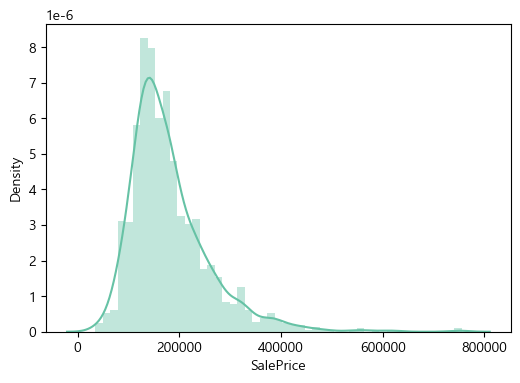

In [73]:
sns.set_palette('Set2')
sns.distplot(train_data['SalePrice']);

In [74]:
print(f'왜도 (Skewness) :', train_data['SalePrice'].skew())
print(f'첨도 (Kurtosis) :', train_data['SalePrice'].kurt())

왜도 (Skewness) : 1.8828757597682129
첨도 (Kurtosis) : 6.536281860064529


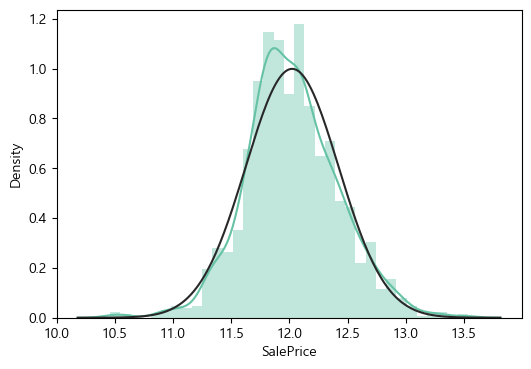

In [75]:
# 정규화
train_data['SalePrice'] = np.log1p(train_data['SalePrice'])

sns.set_palette('Set2')
sns.distplot(train_data['SalePrice'], fit=norm);

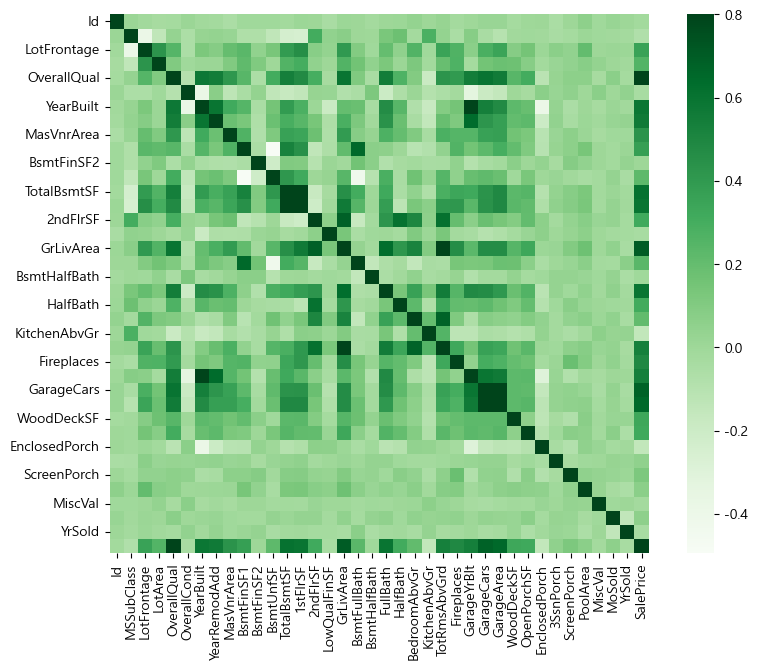

In [76]:
corr_matrix = train_data.corr() 

plt.figure(figsize=(10, 7))
sns.heatmap(corr_matrix, vmax=0.8, square=True, cmap='Greens');

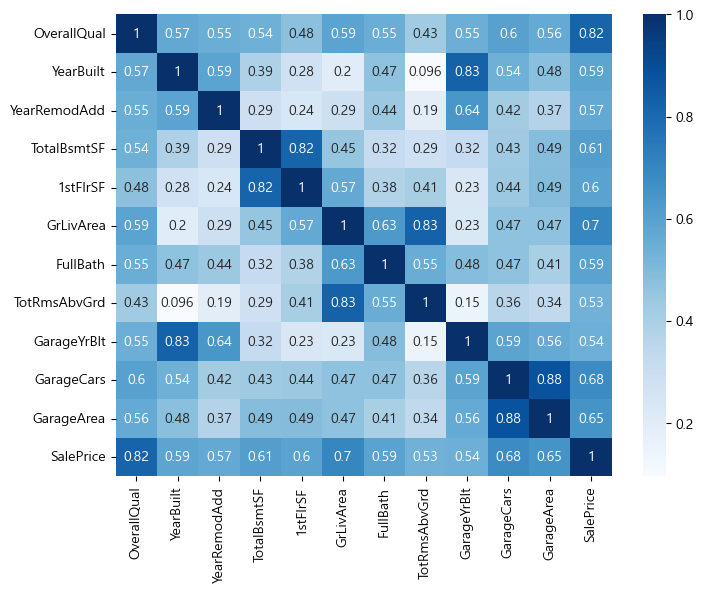

In [77]:
highest_corr = corr_matrix.index[abs(corr_matrix['SalePrice']) > 0.5]

plt.figure(figsize=(8, 6))
sns.heatmap(train_data[highest_corr].corr(), annot=True, cmap='Blues');

In [78]:
corr_matrix['SalePrice'].sort_values(ascending=False)

SalePrice        1.000000
OverallQual      0.817185
GrLivArea        0.700927
GarageCars       0.680625
GarageArea       0.650888
TotalBsmtSF      0.612134
1stFlrSF         0.596981
FullBath         0.594771
YearBuilt        0.586570
YearRemodAdd     0.565608
GarageYrBlt      0.541073
TotRmsAbvGrd     0.534422
Fireplaces       0.489450
MasVnrArea       0.430809
BsmtFinSF1       0.372023
LotFrontage      0.355879
WoodDeckSF       0.334135
OpenPorchSF      0.321053
2ndFlrSF         0.319300
HalfBath         0.313982
LotArea          0.257320
BsmtFullBath     0.236224
BsmtUnfSF        0.221985
BedroomAbvGr     0.209043
ScreenPorch      0.121208
PoolArea         0.069798
MoSold           0.057330
3SsnPorch        0.054900
BsmtFinSF2       0.004832
BsmtHalfBath    -0.005149
Id              -0.017942
MiscVal         -0.020021
OverallCond     -0.036868
YrSold          -0.037263
LowQualFinSF    -0.037963
MSSubClass      -0.073959
KitchenAbvGr    -0.147548
EnclosedPorch   -0.149050
Name: SalePr

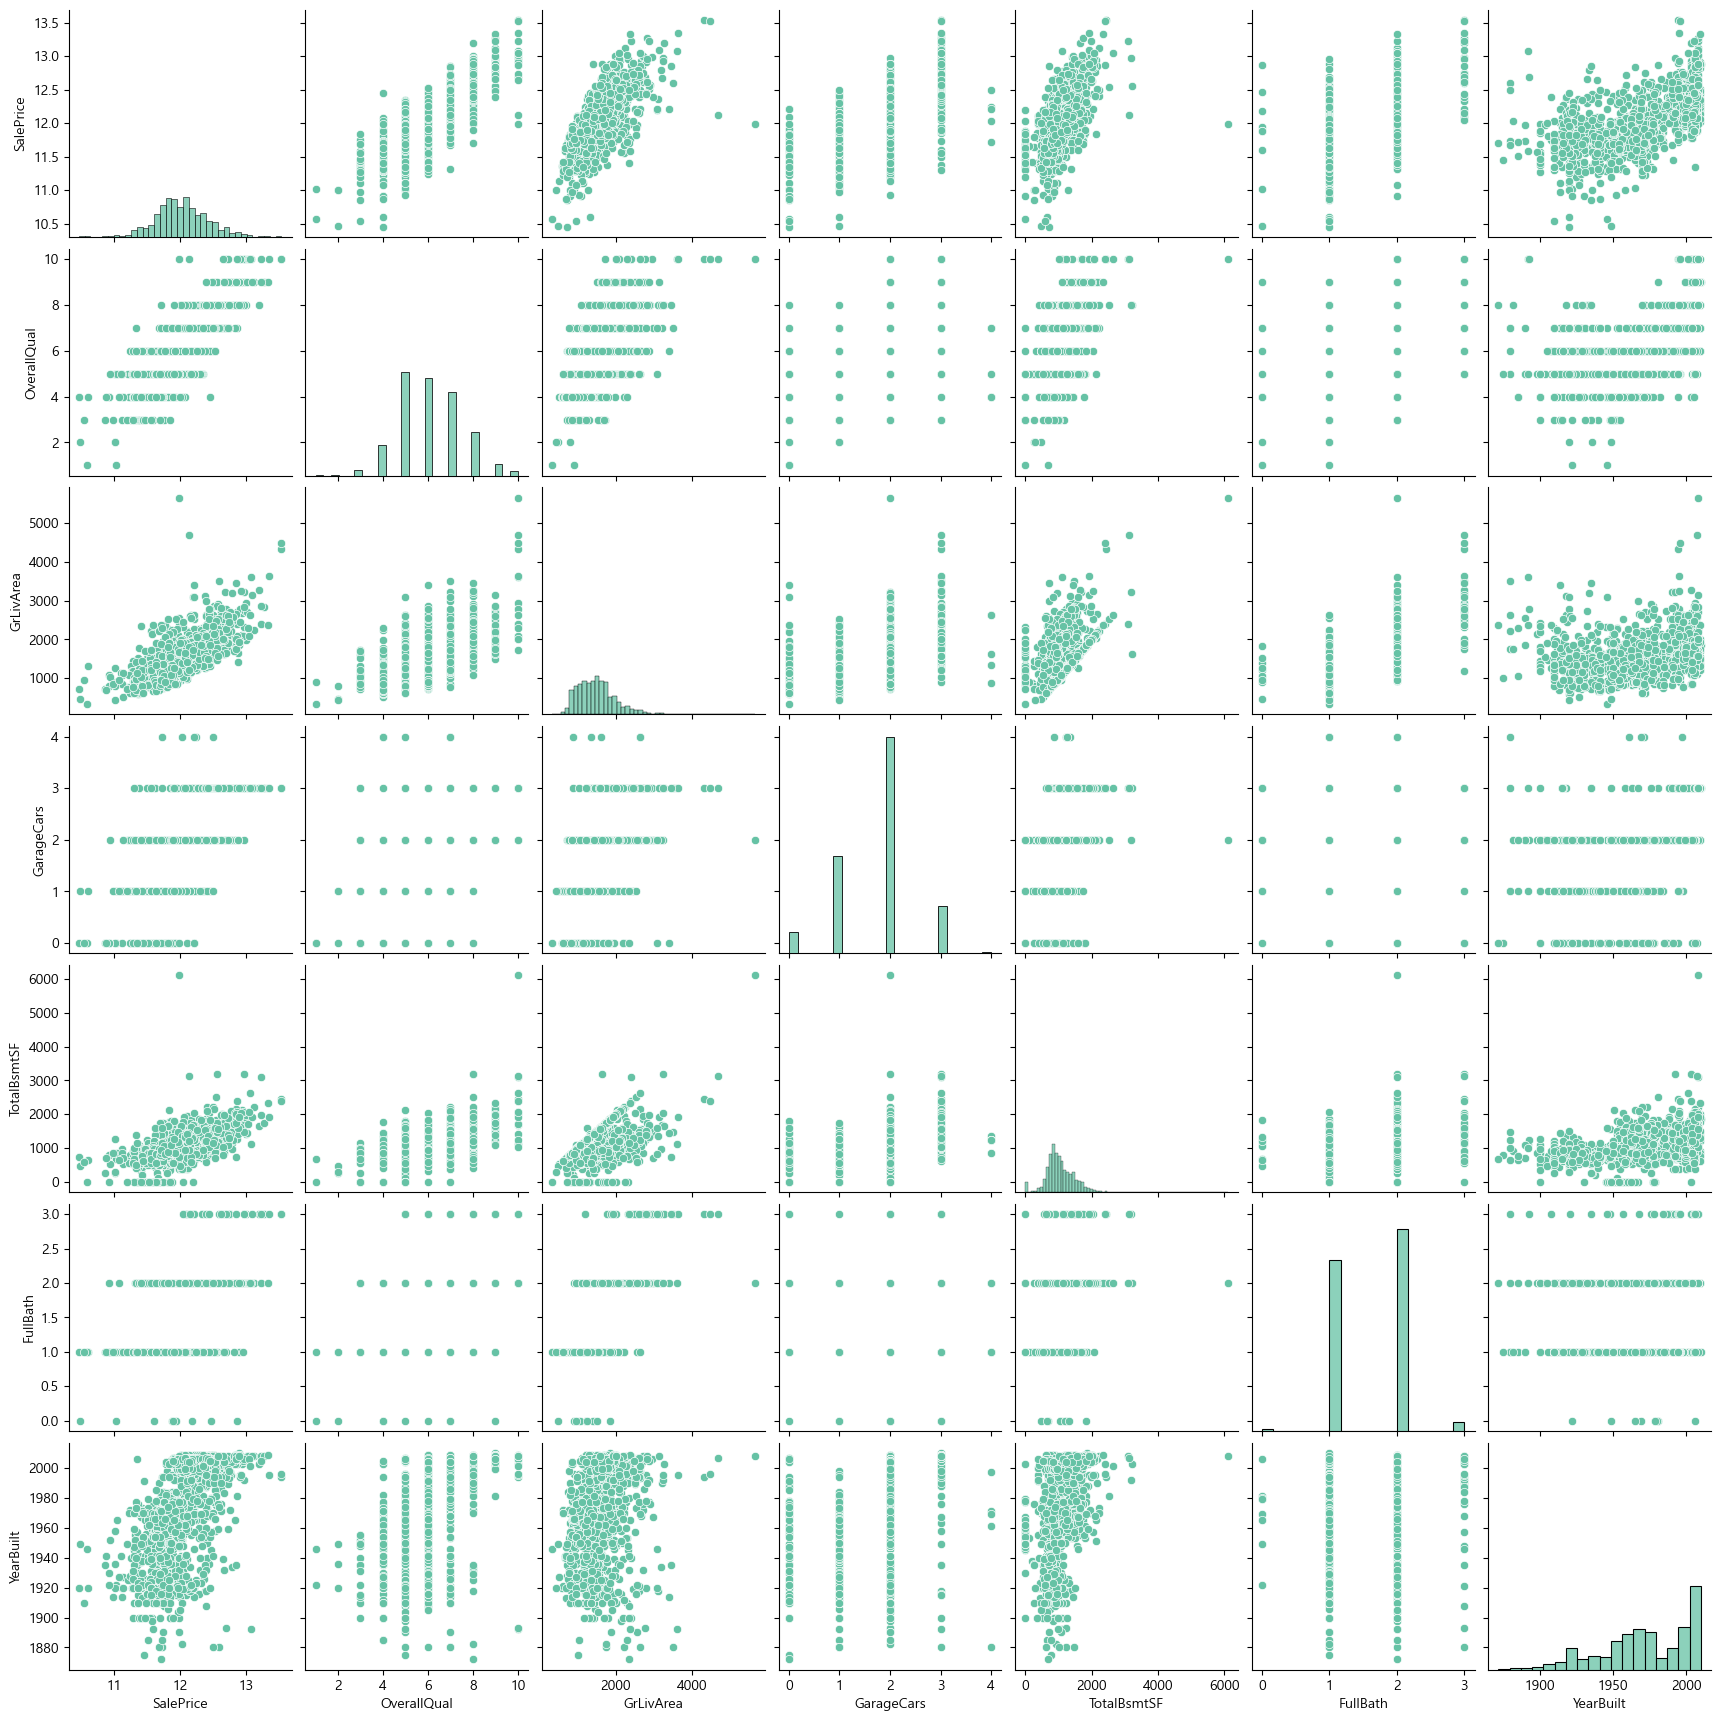

In [79]:
cols = ['SalePrice', 'OverallQual', 'GrLivArea', 'GarageCars', 'TotalBsmtSF', 'FullBath', 'YearBuilt']

sns.set_palette('Set2')
sns.pairplot(train_data[cols]);

In [80]:
y_train = train_data['SalePrice']
test_id = test_data['Id'].values

all_data = pd.concat([train_data, test_data], axis=0, sort=False)
all_data = all_data.drop(['Id', 'SalePrice'], axis=1)

In [81]:
Total = all_data.isnull().sum().sort_values(ascending=False)
percent = (all_data.isnull().sum() / all_data.isnull().count()).sort_values(ascending=False)

nan_data = pd.concat([Total, percent], axis=1, keys=['Total', 'Percent'])
nan_data.head(15)

,Total,Percent
PoolQC,2909,0.996574
MiscFeature,2814,0.964029
Alley,2721,0.932169
Fence,2348,0.804385
FireplaceQu,1420,0.486468
LotFrontage,486,0.166495
GarageYrBlt,159,0.054471
GarageFinish,159,0.054471
GarageQual,159,0.054471
GarageCond,159,0.054471


In [82]:
# 1% 이상의 결측치를 가진 특성 제거
all_data.drop((nan_data[nan_data['Percent'] > 0.1]).index, axis=1, inplace=True)
all_data.isnull().sum()

MSSubClass       0
MSZoning         4
LotArea          0
Street           0
LotShape         0
                ..
MiscVal          0
MoSold           0
YrSold           0
SaleType         1
SaleCondition    0
Length: 73, dtype: int64

In [83]:
total_nan = all_data.isnull()

In [84]:
num_imputer = SimpleImputer(strategy='median')
cat_imputer = SimpleImputer(strategy='most_frequent')

In [85]:
num_nan = all_data[total_nan].select_dtypes(include=[np.number]).columns
cat_nan = all_data[total_nan].select_dtypes(include=['object']).columns

all_data[num_nan] = num_imputer.fit_transform(all_data[num_nan])
all_data[cat_nan] = cat_imputer.fit_transform(all_data[cat_nan])

In [86]:
all_data.drop(['Utilities'], axis=1, inplace=True)

In [87]:
num = all_data.select_dtypes(include=[np.number]).columns
skew = all_data[num].apply(lambda x: skew(x)).sort_values(ascending=False)

# 왜도가 0.5 이상인 특성
high_skew = skew[abs(skew) > 0.5]
high_skew

MiscVal          21.947195
PoolArea         16.898328
LotArea          12.822431
LowQualFinSF     12.088761
3SsnPorch        11.376065
KitchenAbvGr      4.302254
BsmtFinSF2        4.146143
EnclosedPorch     4.003891
ScreenPorch       3.946694
BsmtHalfBath      3.931594
MasVnrArea        2.613592
OpenPorchSF       2.535114
WoodDeckSF        1.842433
1stFlrSF          1.469604
BsmtFinSF1        1.425378
MSSubClass        1.375457
GrLivArea         1.269358
TotalBsmtSF       1.162616
BsmtUnfSF         0.919703
2ndFlrSF          0.861675
TotRmsAbvGrd      0.758367
Fireplaces        0.733495
HalfBath          0.694566
BsmtFullBath      0.624832
OverallCond       0.570312
YearBuilt        -0.599806
dtype: float64

In [88]:
# 높은 왜도를 가지는 특성을 로그 변환
all_data[high_skew.index] = np.log1p(all_data[high_skew.index])

In [89]:
all_data['TotalSF'] = all_data['TotalBsmtSF'] + all_data['1stFlrSF'] + all_data['2ndFlrSF']

In [90]:
# 더미 변수화 (One-Hot Encoding)
all_data = pd.get_dummies(all_data)
all_data.head()

,MSSubClass,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,...,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,4.110874,9.042040,7.0,1.791759,7.602900,2003.0,5.283204,6.561031,0.0,5.017280,...,0,0,0,1,0,0,0,0,1,0
1,3.044522,9.169623,6.0,2.197225,7.589336,1976.0,0.000000,6.886532,0.0,5.652489,...,0,0,0,1,0,0,0,0,1,0
2,4.110874,9.328212,7.0,1.791759,7.601902,2002.0,5.093750,6.188264,0.0,6.075346,...,0,0,0,1,0,0,0,0,1,0
3,4.262680,9.164401,7.0,1.791759,7.557995,1970.0,0.000000,5.379897,0.0,6.293419,...,0,0,0,1,1,0,0,0,0,0
4,4.110874,9.565284,8.0,1.791759,7.601402,2000.0,5.860786,6.486161,0.0,6.196444,...,0,0,0,1,0,0,0,0,1,0


In [91]:
# 데이터 분할
x_train = all_data[:len(y_train)]
x_test = all_data[len(y_train):]

In [92]:
x_train.shape, x_test.shape

((1460, 268), (1459, 268))

In [93]:
reg = LGBMRegressor(n_jobs=-1, random_state=42, max_depth=3)

param_distribs = {'n_estimators': randint(1000, 1500),
                  'learning_rate': uniform(0.01, 0.1)
                 }

rnd_search = RandomizedSearchCV(reg, param_distributions=param_distribs, n_iter=100, cv=5, scoring='r2', random_state=42, n_jobs=-1, verbose=1)
rnd_search.fit(x_train, y_train)

print(rnd_search.best_params_, rnd_search.best_score_)

reg = rnd_search.best_estimator_
scores = cross_val_score(reg, x_train, y_train, cv=20, scoring='r2', n_jobs=-1)
print(scores.mean())

Fitting 5 folds for each of 100 candidates, totalling 500 fits
{'learning_rate': 0.03897514529137681, 'n_estimators': 1085} 0.9029007463129295
0.9001332451073998


In [94]:
reg = rnd_search.best_estimator_

reg.fit(x_train, y_train)

LGBMRegressor(learning_rate=0.03897514529137681, max_depth=3, n_estimators=1085,
              random_state=42)

In [95]:
# 데이터 처리 과정에서 로그 변환으로 정규화 했으므로 지수 변환을 통한 역변환이 필요
y_pred = np.floor(np.expm1(reg.predict(x_test)))
y_pred

array([118821., 154251., 182782., ..., 169084., 115531., 238001.])

In [96]:
submission = pd.DataFrame({
    'Id': test_id,
    'SalePrice': y_pred
    })

submission.to_csv('submission.csv', index=False)